# Model Evaluation


In [14]:
import os
import re
import numpy as np
import cv2
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
ls

EvalMetrics.ipynb              hyperion_scripts/
EvalMetrics_from_WandB.ipynb   hyperparameter_search.py
LICENSE*                       models/
Plot-Train-Losses.ipynb        options/
README.md                      requirements.txt*
checkpoints/                   results/
data/                          scripts/
datasets/                      scripts_tested/
docs/                          test.py
environment.yml*               test_hyperparameter_search.py
eval.ipynb                     train.py
facenet-pytorch/               unused/
gray_env/                      util/


In [ ]:
# gray2real final model output directory
result_image_path = "./results/gray2real_final/test_300/images"
print(sorted(os.listdir(result_image_path))[:5])

['0000_fake_B.png', '0000_fake_B_2.png', '0000_real_A.png', '0000_real_B.png', '0001_fake_B.png']


In [6]:
# Create matching fake_B_2 and real_B image pairs
def make_image_path_pairs(dir):
    image_pairs = []
    assert os.path.isdir(dir), f"{dir} is not a valid directory"

    fake_regex = r"(\d+)_fake_B_2.png"
    real_regex = r"(\d+)_real_B.png"
    fake_paths = {}
    real_paths = {}

    for root, _, fnames in sorted(os.walk(dir)):
        for fname in fnames:
            path = os.path.join(root, fname)
            if re.match(fake_regex, fname):
                key = re.match(fake_regex, fname)[1]
                fake_paths[key] = path
            elif re.match(real_regex, fname):
                key = re.match(real_regex, fname)[1]
                real_paths[key] = path

    for key in fake_paths:
        if key in real_paths:
            image_pairs.append((fake_paths[key], real_paths[key]))

    return image_pairs

In [7]:
# Load image pairs
image_path_pairs = make_image_path_pairs(result_image_path)
image_pairs = [(cv2.imread(fake), cv2.imread(real)) for fake, real in image_path_pairs]

In [8]:
# Define evaluation metrics
def MAE(imageA, imageB):
    abs_error = np.sum(np.abs(imageA.astype("float") - imageB.astype("float")))
    return abs_error / (imageA.shape[0] * imageB.shape[1] * imageB.shape[2])


def RMSE(imageA, imageB):
    sq_error = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    mse = sq_error / (imageA.shape[0] * imageB.shape[1] * imageB.shape[2])
    return np.sqrt(mse)

In [9]:
# Compute L1, L2, SSIM
l1_distances, l2_distances, ssims = [], [], []
for fake, real in image_pairs:
    l1_distances.append(MAE(fake, real))
    l2_distances.append(RMSE(fake, real))
    ssims.append(ssim(fake, real, channel_axis=2, win_size=3))

# Report results
print(f"✅ Evaluated {len(image_pairs)} image pairs")
print(f"📏 Average L1 (MAE):  {np.mean(l1_distances):.4f}")
print(f"📐 Average L2 (RMSE): {np.mean(l2_distances):.4f}")
print(f"🧠 Average SSIM:      {np.mean(ssims):.4f}")

✅ Evaluated 50 image pairs
📏 Average L1 (MAE):  5.8034
📐 Average L2 (RMSE): 9.4463
🧠 Average SSIM:      0.9267


### Visualize sample image pairs


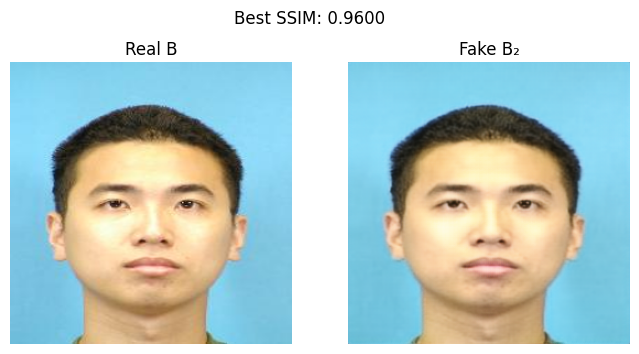

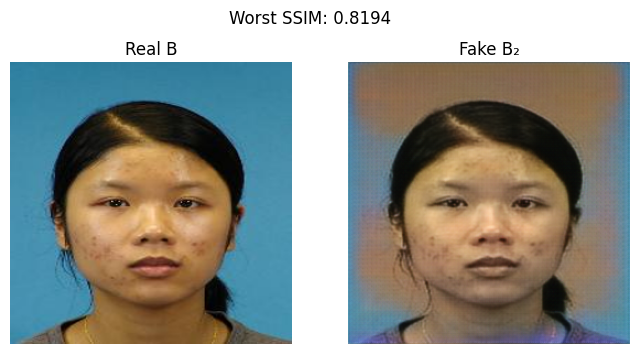

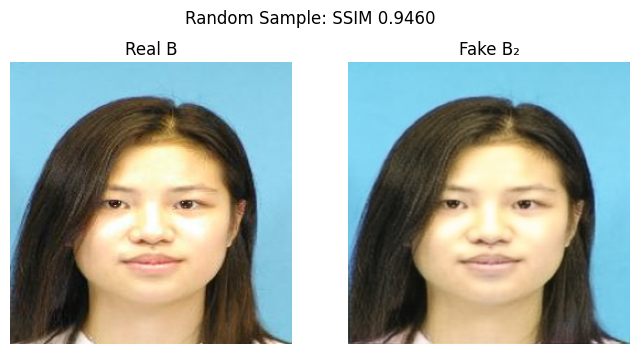

In [ ]:
# Visualize 3 pairs of images with best, worst, and random SSIM
def show_image_pair(fake, real, title, idx=None):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(cv2.cvtColor(real, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Real B")
    axs[0].axis("off")
    axs[1].imshow(cv2.cvtColor(fake, cv2.COLOR_BGR2RGB))
    axs[1].set_title("Fake B₂")
    axs[1].axis("off")
    fig.suptitle(title)
    if idx is not None:
        fig.savefig(f"evaluation_sample_{idx}.png")
    plt.show()


# Best SSIM
best_idx = np.argmax(ssims)
show_image_pair(
    *image_pairs[best_idx], title=f"Best SSIM: {ssims[best_idx]:.4f}", idx="best"
)

# Worst SSIM
worst_idx = np.argmin(ssims)
show_image_pair(
    *image_pairs[worst_idx], title=f"Worst SSIM: {ssims[worst_idx]:.4f}", idx="worst"
)

# Random SSIM
rand_idx = np.random.randint(len(image_pairs))
show_image_pair(
    *image_pairs[rand_idx],
    title=f"Random Sample: SSIM {ssims[rand_idx]:.4f}",
    idx="random",
)

In [19]:
df = pd.DataFrame(
    {
        "Filename": [os.path.basename(fake) for fake, _ in image_path_pairs],
        "L1": l1_distances,
        "L2": l2_distances,
        "SSIM": ssims,
    }
)
print(df.head())

            Filename         L1         L2      SSIM
0  0019_fake_B_2.png  27.184713  38.651882  0.819410
1  0028_fake_B_2.png   4.100210   6.860512  0.929334
2  0018_fake_B_2.png   7.612574  14.389010  0.910292
3  0029_fake_B_2.png   4.842478   7.318231  0.925219
4  0023_fake_B_2.png   4.897293   7.044949  0.926432


In [21]:
df.to_csv("gray2real_final_metrics.csv", index=False)
print("📁 Saved: gray2real_final_metrics.csv")

📁 Saved: gray2real_final_metrics.csv
